In [1]:
import torch
import numpy as np
import pandas
import csv
import wget

In [2]:
import numpy as np 
from copy import deepcopy
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from scipy.special import softmax

### image transformation functions ###
# function to half the mnist image to use as a probe query
"""
def halve_continuous_img(img,sigma=None):
	# mnist
	if len(img) == (28 * 28):
		H,W = img.reshape(28,28).shape
		i = deepcopy(img.reshape(28,28))
		i[H//2:H,:] = 0
		return i
	# cifar -- this is a bit of a hack doing it like this
	elif len(img) == (32 * 32 * 3):
		C,H,W = img.reshape(3,32,32).shape
		i = deepcopy(img.reshape(3,32,32))
		i[:,H//2:H,:] = 0
		return i
	else:
		raise ValueError("Input data dimensions not recognized")
""" 
def halve_continuous_img(img, sigma=None,reversed = False):
    return mask_continuous_img(img, 0.5, reversed = reversed)

def mask_continuous_img(img, frac_masked,reversed = False):
	# mnist
	frac_masked = 1-frac_masked
	if len(img) == (28*28):
		i = deepcopy(img.reshape(28,28))
		H,W = i.shape
		if reversed:
			i[0:int(H * frac_masked),:] = 0
		else:
			i[int(H * frac_masked):H,:] = 0
		return i
	elif len(img) == (32 * 32 * 3):
		i = deepcopy(img.reshape(3,32,32))
		C,H,W = i.shape
		if reversed:
			i[:,0:int(H*frac_masked),:] = 0
		else:
			i[:,int(H*frac_masked):H,:] = 0
		return i
	# imagenet
	elif len(img) == (64 * 64 * 3):
		i = deepcopy(img.reshape(3,64,64))
		C,H,W = i.shape
		if reversed:
			i[:,0:int(H*frac_masked),:] = 0
		else:
			i[:,int(H*frac_masked):H,:] = 0
		return i
	else:
		raise ValueError("Input data dimensions not recognized")

def gaussian_perturb_image(img, sigma=0.1):
	#print(img.shape)
	if len(img.shape) != 1:
		total_img_len = np.prod(np.array(img.shape))
		img = img.reshape(total_img_len)
	N = len(img)
	variance = np.tensor(np.identity(N) * sigma).float()
	perturb = np.normal(0,sigma,size=[N,])
	return np.clamp(np.abs(img + perturb),0,1)

def random_mask_frac(img, mask_prob):
    img_shape = img.shape
    flat_img = deepcopy(img).flatten()
    for i in range(len(flat_img)):
        r = np.random.uniform(0,1)
        if r <= mask_prob:
            flat_img[i] = 0.0
    return flat_img.reshape(img_shape)

def random_mask_frac_handle_color(img, mask_prob):
	img_shape = img.shape
	if len(img) == 28*28:
		return random_mask_frac(img, mask_prob)
	elif len(img) == 32*32*3:
		reshp = deepcopy(img).reshape(3,32,32)
		for i in range(32):
			for j in range(32):
				r = np.random.uniform(0,1)
				if r <= mask_prob:
					reshp[:,i,j] = 0
		return reshp.reshape(img_shape)
	elif len(img) == 64*64*3:
		reshp = deepcopy(img).reshape(3,64,64)
		for i in range(64):
			for j in range(64):
				r = np.random.uniform(0,1)
				if r <= mask_prob:
					reshp[:,i,j] = 0
		return reshp.reshape(img_shape)
	else:
		raise ValueError("image shape not recognized")
					

def image_inpaint(img, mask_frac):
    #pixels_to_mask = 
	if len(img) == (28*28):
		i = deepcopy(img.reshape(28,28))
		H,W = i.shape
		pixels_to_mask = int(H * mask_frac // 2)
		i[0:pixels_to_mask,:] = 0
		i[28-pixels_to_mask:28,:] = 0
		i[:, 0:pixels_to_mask] = 0
		i[:, 28 - pixels_to_mask:28] = 0
		return i
	elif len(img) == (32 * 32 * 3):
		i = deepcopy(img.reshape(3,32,32))
		C,H,W = i.shape
		pixels_to_mask = int(H * mask_frac // 2)
		i[:,0:pixels_to_mask,:] = 0
		i[:,32-pixels_to_mask:32,:] = 0
		i[:,:, 0:pixels_to_mask] = 0
		i[:,:, 32 - pixels_to_mask:32] = 0
		return i
	# imagenet
	elif len(img) == (64 * 64 * 3):
		i = deepcopy(img.reshape(3,64,64))
		C,H,W = i.shape
		pixels_to_mask = int(H * mask_frac // 2)
		i[:,0:pixels_to_mask,:] = 0
		i[:,64-pixels_to_mask:64,:] = 0
		i[:,:, 0:pixels_to_mask] = 0
		i[:,:, 64 - pixels_to_mask:64] = 0
		return i
	else:
		raise ValueError("Input data dimensions not recognized")

def binary_to_bipolar(x):
    return np.sign(x - 0.5)

def bipolar_to_binary(x):
  	return (x + 1) /2

### update functions ###
### potential separation functions --  linear, sublinear (sqrt, log), polynomial, exponential, max ###
def separation_log(x, param):
	return np.log(x)

def separation_identity(x,param):
	return x

def separation_softmax(x,param):
	return softmax(param * x) # param = beta = softmax temperature

def separation_polynomial(x,param):	
    return np.pow(x, param)

def separation_square(x,param):
	return separation_polynomial(x,2)

def separation_cube(x,param):
	return separation_polynomial(x,3)

def separation_sqrt(x,param):
	return separation_polynomial(x,0.5)

def separation_quartic(x,param):
	return separation_polynomial(x,4)

def separation_ten(x,param):
	return separation_polynomial(x,10)

def separation_max(x, param):
	z = np.zeros(len(x))
	idx = np.argmax(x).item()
	z[idx] = 1
	return z 

EPSILON = 1e-4
# update rule of the Modern Continuous Hopfield Network which is closely related to attention etc. Computes similarity scores according in the dot-product or cosine similarity space
def MCHN_update_rule(X,z,beta, norm=True):
	out = X.T @ softmax(beta * X @ z,axis=0)
	if norm:
		return out / np.sum(out)
	else:
		return out

# PC associative memory update rule -- Computes similarity scores in the euclidean distance/ prediction error space
def PC_update_rule(X,z,beta,f = np.square):
	e = z - X # compute prediction error
	return X.T @ softmax(beta * -np.sum(f(e), axis=1))

def dot_product_distance(X,z):
	return X @ z.reshape(len(z[0,:]))

def normalized_dot_product(X,z):
	norm_X = X / np.sum(X, axis=1).reshape(X.shape[0],1)
	norm_z = z / np.sum(z)
	dots = norm_X @ norm_z.reshape(len(z[0,:]))
	recip = dots
	norm_dot = recip / np.sum(recip)
	return norm_dot


def cosine_similarity(X,z):
	return (X @ z.reshape(len(z[0,:]))) / (np.norm(X) * np.norm(z))

def manhatten_distance(X,z):
	return 1/( 1e-6 + np.sum(np.abs(z - X),axis=1))
	#return -np.sum(np.abs(z - X), axis=1)

def euclidean_distance(X,z):
	return 1/(1e-6 + np.sum(np.square(z - X),axis=1))
	#return -np.sum(np.square(z - X),axis=1)

def general_update_rule(X,z,beta,sim, sep=separation_softmax,sep_param=1,norm=True):
	sim_score = beta * sim(X,z)
	#print("SIMS: ", sim_score)
	if norm:
		sim_score = sim_score / np.sum(sim_score)
	sep_score = sep(sim_score,sep_param)
	if norm:
		sep_score = sep_score / np.sum(sep_score)
	#print("AUTO SEP SCORE: ", sep_score)
	out = X.T @ sep_score
	return out


def heteroassociative_update_rule(M,P,z,beta, sim,sep=softmax, sep_param=1, norm=True):
	sim_score = beta * sim(M,z)
	if norm:
		sim_score = sim_score / np.sum(sim_score)
	#print(sim_score.shape)
	sep_score = sep(sim_score, sep_param)
	#print(sep_score.shape)
	if norm:
		sep_score = sep_score / np.sum(sep_score)
	out = P.T @ sep_score
	return out

# inefficient implementation but works well enough
def KL_divergence(X,z):
	KL_matrix = np.zeros_like(X)
	for i in range(len(X)):
		x = X[i,:]
		x_norm = x / np.sum(x)
		z_norm = z / np.sum(z)
		KL_matrix[i,:] = x_norm * (np.log(x_norm + EPSILON) - np.log(z_norm + EPSILON))
	return 1/np.sum(KL_matrix,axis=1)

def reverse_KL_divergence(X,z):
	KL_matrix = np.zeros_like(X)
	for i in range(len(X)):
		x = X[i,:]
		x_norm = x / np.sum(x)
		z_norm = z / np.sum(z)
		KL_matrix[i,:] = z_norm* (np.log(z_norm + EPSILON) - np.log(x_norm + EPSILON))
	return 1/np.sum(KL_matrix,axis=1)

def Jensen_Shannon_divergence(X,z):
	return 1/(0.5 * KL_divergence(X,z) + 0.5 * reverse_KL_divergence(X,z))


In [3]:
def manhatten_distance(X,z):
    dist=1/(1e-6 + np.sum(np.abs(z - X),axis=1))
    return dist

def mask_n_features(x, n_mask):
    x = copy.deepcopy(x)
    n_features = x.shape[0]
    mask = np.random.choice(n_features, n_mask, replace=False)
    x[mask] = 0
    return x

import copy
def PC_retrieve_store_continuous(imgs,N, P = None, beta=1,num_plot = 5,mask=0,similarity_metric="error",sim_fn=None, image_perturb_fn = halve_continuous_img,sigma=0.5,sep_fn=separation_max, sep_param=1, use_norm = True,ERROR_THRESHOLD = 60, network_type="", return_sqdiff_outputs = False, plot_example_reconstructions = False):
    X = copy.deepcopy(imgs[:N])
    if P is not None:
        P = copy.deepcopy(P[:N])
    img_len = np.prod(np.array(X[0].shape))
    if len(X.shape) != 2:
        if network_type == "classical_hopfield":
            X = reshape_img_list(X, img_len, opt_fn = binary_to_bipolar)
        else:
            X = reshape_img_list(X, img_len)
    N_correct = 0
    mse = 0
    for j in range(N-1):
        if network_type == "classical_hopfield":
            z = binary_to_bipolar(image_perturb_fn(X[j,:],mask)).reshape(1, img_len)
        else:
            z = image_perturb_fn(X[j,:], mask).reshape(1,img_len)
        if P is None: # autoassociative
            out = general_update_rule(X,z,beta, sim=sim_fn,sep=sep_fn, sep_param=sep_param,norm=use_norm).reshape(img_len)
            if network_type == "classical_hopfield":
                out = binary_to_bipolar(np.sign(out))
            sqdiff = np.sum(np.square(X[j] - out))
            if plot_example_reconstructions:
                plt.imshow(X[j,:].reshape(3,32,32).permute(1,2,0))
                plt.show()
                plt.imshow(z.reshape(3,32,32).permute(1,2,0))
                plt.show()
                plt.imshow(out.reshape(3,32,32).permute(1,2,0))
                plt.show()

        else: # heteroassociative
            out = heteroassociative_update_rule(X,X,z,beta, sim=sim_fn,sep=sep_fn, sep_param=sep_param, norm=use_norm).reshape(img_len)
            if network_type == "classical_hopfield":
                out = binary_to_bipolar(np.sign(out))
            sqdiff = np.sum(np.square(P[j] - out))

        if j % 20 == 0:
            print(f"SQDIFF {j}:", sqdiff)
        if np.abs(sqdiff) <= ERROR_THRESHOLD:
            N_correct +=1
        mse += sqdiff
# 		if j < num_plot:
# 			fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(12,4))
# 			titles = ["Original","Masked","Reconstruction"]
# 			plot_list = [X[j,:], z, out]
# 			for i, ax in enumerate(axs.flatten()):
# 				plt.sca(ax)
# 				#print(imgs[0].shape)
# 				if len(imgs[0].shape) == 3:
# 					plt.imshow(plot_list[i].reshape(imgs[0].shape).permute(1,2,0))
# 				else:
# 					plt.imshow(plot_list[i].reshape(28,28))
# 				plt.title(titles[i])
# 			plt.show()
    return N_correct / (N-1), mse/(N-1), out

In [7]:
# f = pandas.read_csv(wget.download('https://archive.ics.uci.edu/ml/machine-learning-databases/undocumented/connectionist-bench/sonar/sonar.all-data'),header=None)
f = pandas.read_csv('./sonar (1).all-data')
X = np.array(f)[:,:-1]
X=np.array(X,dtype=float)
print(X.dtype, X.shape)

float64 (207, 60)


In [5]:


n_pts = 10
ET = 1
N = np.array(np.linspace(10,len(X), n_pts), dtype=int)
n_mask = 0
use_norm=False
n_trials = 3
acc_mchn = np.zeros((n_pts, n_trials, 2))
mse = np.zeros_like(acc_mchn)
separations = [separation_softmax, separation_max]
sim_fn = euclidean_distance
for s in range(len(separations)):
    for t in range(n_trials):
        for i in range(n_pts):
            shuffled = np.random.choice(X.shape[0], size=X.shape[0],replace=False)
            X = X[shuffled]
            gaussian_noise = np.random.normal(0,0.1,X.shape)
            X_noisy = X + gaussian_noise
            acc_mchn[i,t,s], mse[i,t,s], _ = PC_retrieve_store_continuous(X_noisy, N[i]+1,P=X, image_perturb_fn=mask_n_features, mask=n_mask, ERROR_THRESHOLD=ET, use_norm=use_norm, sep_fn=separations[s], sim_fn=sim_fn)
            # acc_classic, _ = PC_retrieve_store_continuous(X_noisy, N[i]+1,network_type="classical_hopfield",image_perturb_fn=mask_n_features,mask=n_mask, ERROR_THRESHOLD=ET, sep_fn=separations[s])

    # print(f"Accuracy MCHN: {acc_mchn}")

float64 (207, 60)
SQDIFF 0: 0.8075068966724216
SQDIFF 0: 0.618190756388093
SQDIFF 20: 0.5972125932960201
SQDIFF 0: 0.49656034219812223
SQDIFF 20: 0.6804987527467545
SQDIFF 40: 0.5320375938810796
SQDIFF 0: 0.4817557613315936
SQDIFF 20: 0.6534247302908875
SQDIFF 40: 0.8325368744558885
SQDIFF 60: 0.4913710287963122
SQDIFF 0: 0.5111694666465677
SQDIFF 20: 0.6320585971618736
SQDIFF 40: 0.6025624769113823
SQDIFF 60: 0.47108861995604806
SQDIFF 80: 0.7408769392077349
SQDIFF 0: 0.7636319617434054
SQDIFF 20: 0.6072486076181818
SQDIFF 40: 0.4878398792077384
SQDIFF 60: 0.4801708859522239
SQDIFF 80: 0.7425329840273507
SQDIFF 100: 0.3654450982678093
SQDIFF 0: 0.6040438453595968
SQDIFF 20: 0.6199199577003499
SQDIFF 40: 0.7327189838367621
SQDIFF 60: 0.8057673715378003
SQDIFF 80: 0.6493795482230446
SQDIFF 100: 0.7065068209659557
SQDIFF 120: 0.6300821497158312
SQDIFF 140: 0.42600516655141246
SQDIFF 0: 0.5394694398988881
SQDIFF 20: 0.5958479161847583
SQDIFF 40: 0.6685951089357358
SQDIFF 60: 0.68855310411

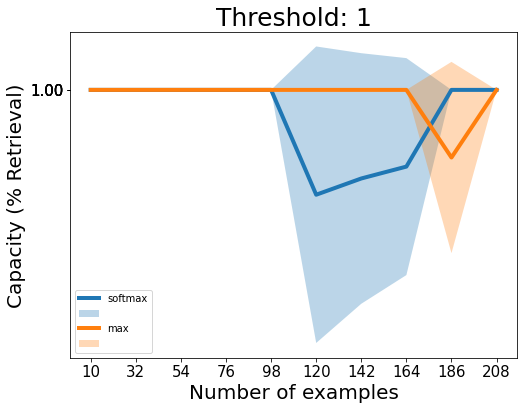

In [6]:
import matplotlib.pyplot as plt
acc_softmax = acc_mchn[:,:,0]
acc_max = acc_mchn[:,:, 1]
fig=plt.figure(figsize=(8,6))
for acc in [acc_softmax, acc_max]:
    plt.title(f"Threshold: {ET}", fontsize=25)
    plt.plot(acc.mean(1), lw=4)
    plt.xlabel("Number of examples",fontsize=20)
    plt.xticks(range(len(N)), N, fontsize=15)
    plt.yticks(np.linspace(np.min([acc_softmax.min(),acc_max.min()]),1,6).round(2), fontsize=15)
    plt.fill_between(range(len(N)), acc.mean(1)-acc.std(1), acc.mean(1)+acc.std(1) ,alpha=0.3)
    plt.ylabel("Capacity (% Retrieval)",fontsize=20)
plt.legend(['softmax', None,'max',None])
plt.show()

In [8]:
n_pts = 10
ET = 1
n_mask = np.flip(np.array(np.linspace(0,X.shape[1], n_pts), dtype=int))
print(n_mask)
n_trials = 3
use_norm=False
separations = [separation_softmax, separation_max]
acc_mchn = np.zeros((n_pts, n_trials, len(separations)))
mse = np.zeros_like(acc_mchn)
N = X.shape[0]
sim_fn = euclidean_distance # dot product - linear
for s in range(len(separations)):
    for t in range(n_trials):
        for i in range(n_pts):
            shuffled = np.random.choice(X.shape[0], size=X.shape[0],replace=False)
            X = X[shuffled]
            acc_mchn[i,t,s],mse[i,t,s], _ = PC_retrieve_store_continuous(X, N+1,P=X, image_perturb_fn=mask_n_features, mask=n_mask[i], ERROR_THRESHOLD=ET, use_norm=use_norm, sep_fn=separations[s], sim_fn=sim_fn)
            # acc_classic, _ = PC_retrieve_store_continuous(X_noisy, N[i]+1,network_type="classical_hopfield",image_perturb_fn=mask_n_features,mask=n_mask, ERROR_THRESHOLD=ET, sep_fn=separations[s])


[60 53 46 40 33 26 20 13  6  0]
SQDIFF 0: 1.2605268725472845
SQDIFF 20: 0.9217444350607905
SQDIFF 40: 1.9990676620587784
SQDIFF 60: 1.191324798685049
SQDIFF 80: 1.2969084537566526
SQDIFF 100: 2.3676739329970493
SQDIFF 120: 1.3797549396250914
SQDIFF 140: 1.2996595731921194
SQDIFF 160: 1.12853690898572
SQDIFF 180: 1.0173080649743913
SQDIFF 200: 1.7798957064170118
SQDIFF 0: 1.259934259101333
SQDIFF 20: 1.7507954184921617
SQDIFF 40: 1.9092731722810257
SQDIFF 60: 1.7747770045292803
SQDIFF 80: 3.337025639097389
SQDIFF 100: 1.4107225850334257
SQDIFF 120: 1.5288603148029096
SQDIFF 140: 1.241330865768971
SQDIFF 160: 1.9173829244471734
SQDIFF 180: 1.1617249632844266
SQDIFF 200: 1.2757771608377888
SQDIFF 0: 0.9432660544279126
SQDIFF 20: 0.924975465158293
SQDIFF 40: 1.1479260901084742
SQDIFF 60: 1.6568382625334788
SQDIFF 80: 2.285286734206864
SQDIFF 100: 1.4141857097759423
SQDIFF 120: 1.908621214396013
SQDIFF 140: 1.2961062635819214
SQDIFF 160: 2.840602218007219
SQDIFF 180: 3.251798075655237
SQDIF

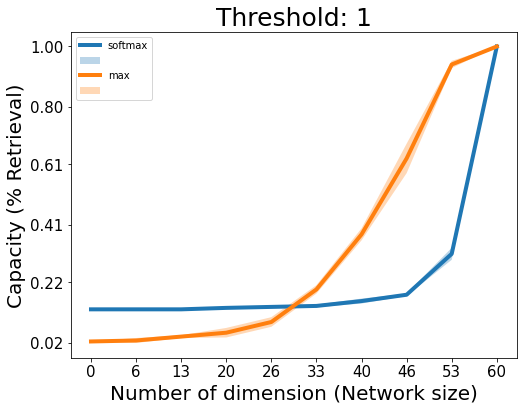

In [9]:
import matplotlib.pyplot as plt
acc_softmax = acc_mchn[:,:,0]
acc_max = acc_mchn[:,:, 1]
fig=plt.figure(figsize=(8,6))
for acc in [acc_softmax, acc_max]:
    plt.title(f"Threshold: {ET}", fontsize=25)
    plt.plot(acc.mean(1), lw=4)
    plt.xlabel("Number of dimension (Network size)",fontsize=20)
    plt.xticks(range(len(n_mask)), np.flip(n_mask), fontsize=15)
    plt.yticks(np.linspace(np.min([acc_softmax.min(),acc_max.min()]),1,6).round(2), fontsize=15)
    plt.fill_between(range(len(n_mask)), acc.mean(1)-acc.std(1), acc.mean(1)+acc.std(1) ,alpha=0.3)
    plt.ylabel("Capacity (% Retrieval)",fontsize=20)
plt.legend(['softmax', None,'max',None])
plt.show()

[-3.28113416  1.64975906] [[ 0.214125   -0.14295233]
 [-0.14295233  0.0997817 ]]


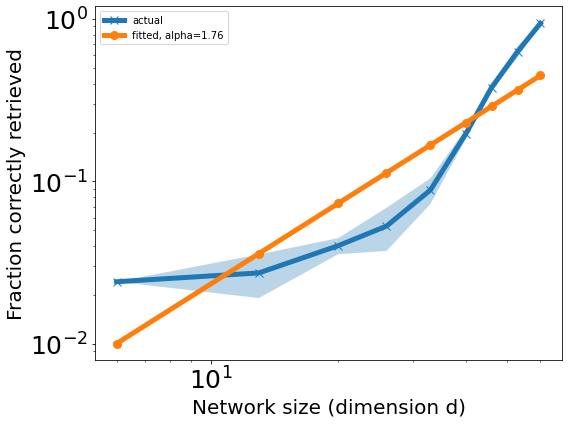

In [18]:
from scipy.optimize import curve_fit
mse_softmax = mse[:,:,0]
mse_max = mse[:,:,1]
def powlaw(x, a, b) :
    return a * np.power(x, b)
def linlaw(x, a, b) :
    return a + x * b

def curve_fit_log(xdata, ydata) :
    """Fit data to a power law with weights according to a log scale"""
    # Weights according to a log scale
    # Apply fscalex
    xdata_log = np.log10(xdata)
    # Apply fscaley
    ydata_log = np.log10(ydata)
    # Fit linear
    popt_log, pcov_log = curve_fit(linlaw, xdata_log, ydata_log)
    print(popt_log, pcov_log)
    # Apply fscaley^-1 to fitted data
    ydatafit_log = np.power(10, linlaw(xdata_log, *popt_log))
    # There is no need to apply fscalex^-1 as original data is already available
    return (popt_log, pcov_log, ydatafit_log)
x,y=np.flip(n_mask)[1:], acc_max.mean(1)[:-1]
(popt_log, pcov_log, ydatafit_log) = curve_fit_log(x,y)


fig=plt.figure(figsize=(8,6))

plt.plot(x,y, marker='x', lw=5, markersize=8)
plt.plot(x,ydatafit_log, marker='o', lw=5,markersize=8)
plt.fill_between(x, (acc_max.mean(1)-acc.std(1))[:-1], (acc_max.mean(1)+acc.std(1))[:-1] ,alpha=0.3)
# plt.plot(1/np.flip(n_mask), np.flip(np.exp(n_mask)), marker='o' )
plt.legend(['actual', 'fitted, alpha=1.76'])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Network size (dimension d)', fontsize=20)
plt.ylabel('Fraction correctly retrieved', fontsize=20)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
fig.savefig('hop_scaling.png')
plt.tight_layout()

In [10]:
# fig=plt.figure(figsize=(8,6))
# for acc in [np.flip(acc_softmax), np.flip(acc_max), np.flip(acc_identity)]:
#     plt.title(f"Masking: Threshold {ET}", fontsize=25)
#     plt.plot(acc.mean(1)*N, lw=4)
#     plt.xlabel("Number of neurons (dimension of pattern)",fontsize=20)
#     plt.xticks(range(len(n_mask)), n_mask, fontsize=15)
#     plt.yticks(np.linspace(acc_softmax.min()*N,acc_max.max()*N,6).round(2), fontsize=15)
#     plt.fill_between(range(len(n_mask)), acc.mean(1)*N-acc.std(1)*N, acc.mean(1)*N+acc.std(1)*N ,alpha=0.3)
#     plt.ylabel("Capacity",fontsize=20)
# plt.legend(['softmax', None,'max',None])
# plt.show()

In [11]:
# fig=plt.figure(figsize=(8,6))
# for acc in [acc_softmax, acc_max]:
#     plt.title(f"Threshold: {ET}", fontsize=25)
#     plt.plot(acc.mean(1), lw=4)
#     plt.xlabel("Number of examples",fontsize=20)
#     plt.xticks(range(len(N)), N, fontsize=15)
#     plt.yticks(np.linspace(acc_softmax.min(),1,6).round(2), fontsize=15)
#     plt.fill_between(range(len(N)), acc.mean(1)-acc.std(1), acc.mean(1)+acc.std(1) ,alpha=0.3)
#     plt.ylabel("Capacity (% Retrieval)",fontsize=20)
# plt.legend(['softmax', None,'max',None])
# plt.show()

In [12]:
X.sum(1).mean(),X.sum(1).std()

(16.879277403846153, 2.340801914782417)

In [13]:
n_pts = 10
N = np.array(np.linspace(0,len(X), n_pts), dtype=int)
N

array([  0,  23,  46,  69,  92, 115, 138, 161, 184, 208])